TOURISM ANALYTICS - REGRESSION MODELING (RATING PREDICTION)

1. LOADING PROCESSED DATA
--------------------------------------------------
Looking for processed data at: ../data/processed/
✓ Master dataset loaded: (14185, 54)
✓ Pre-split data loaded: Train (11348, 49), Test (2837, 49)

2. FEATURE SELECTION AND TARGET PREPARATION
--------------------------------------------------
Target variable: Rating
Available features: 36
Sample features: ['VisitYear', 'VisitMonth', 'VisitMode', 'ContinentId', 'RegionId', 'CountryId', 'CityId', 'AttractionCityId', 'AttractionTypeId', 'CountryId_cities']

Data quality check:
  Missing values in target: 0
  Missing values in features: 0

3. TRAIN-TEST SPLIT AND FEATURE SCALING
--------------------------------------------------
Training set: (11348, 36)
Test set: (2837, 36)
Target distribution in training:
Rating
1     358
2     516
3    1568
4    3438
5    5468
Name: count, dtype: int64
✓ Applied 2 different scaling methods

4. BASELINE MODELS COMPARIS

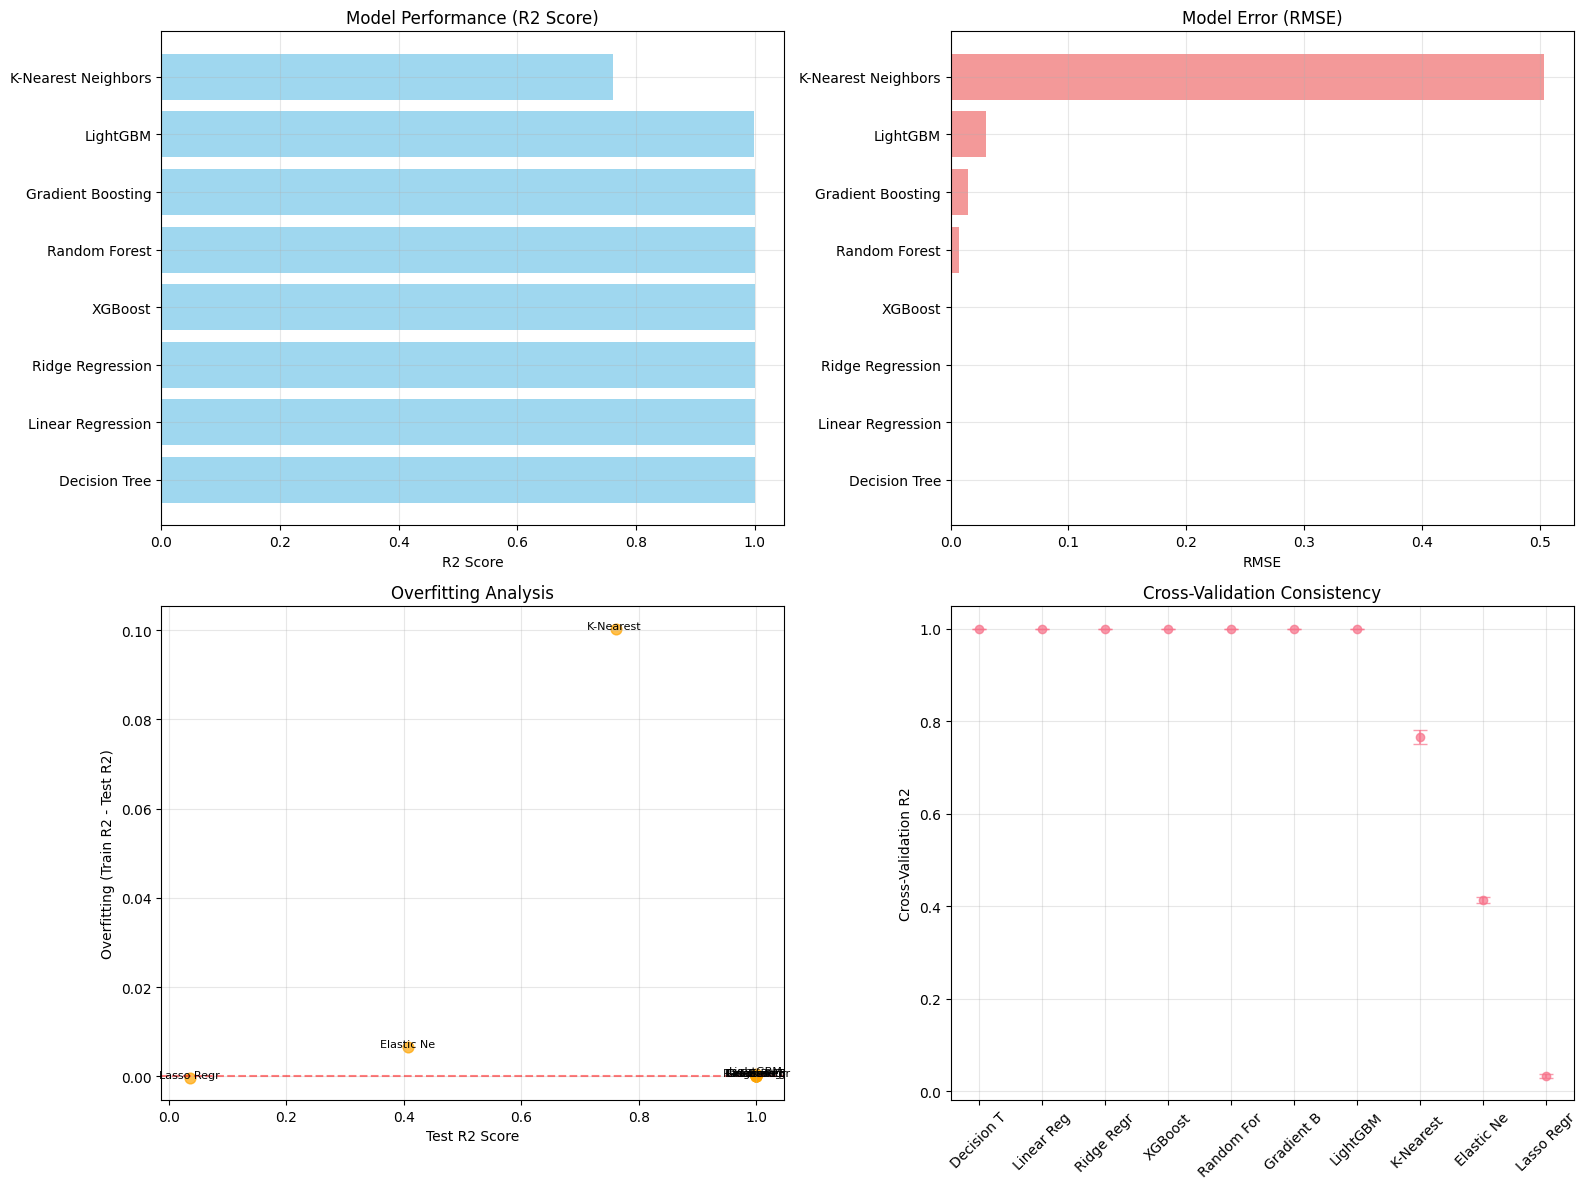

✓ Performance visualizations saved as 'regression_model_comparison.png'

6. HYPERPARAMETER TUNING FOR TOP MODELS
--------------------------------------------------

Tuning Decision Tree with Raw scaling...
  No parameter grid defined for Decision Tree

Tuning Linear Regression with Raw scaling...
  No parameter grid defined for Linear Regression

Tuning Ridge Regression with Standard scaling...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  Best CV R2: 1.0000
  Test R2: 1.0000
  Best params: {'alpha': 0.1}

7. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------

8. PREDICTION ANALYSIS AND ERROR ANALYSIS
--------------------------------------------------
Best performing model: Ridge Regression
Test R2: 1.0000
Test RMSE: 0.0000
Test MAE: 0.0000


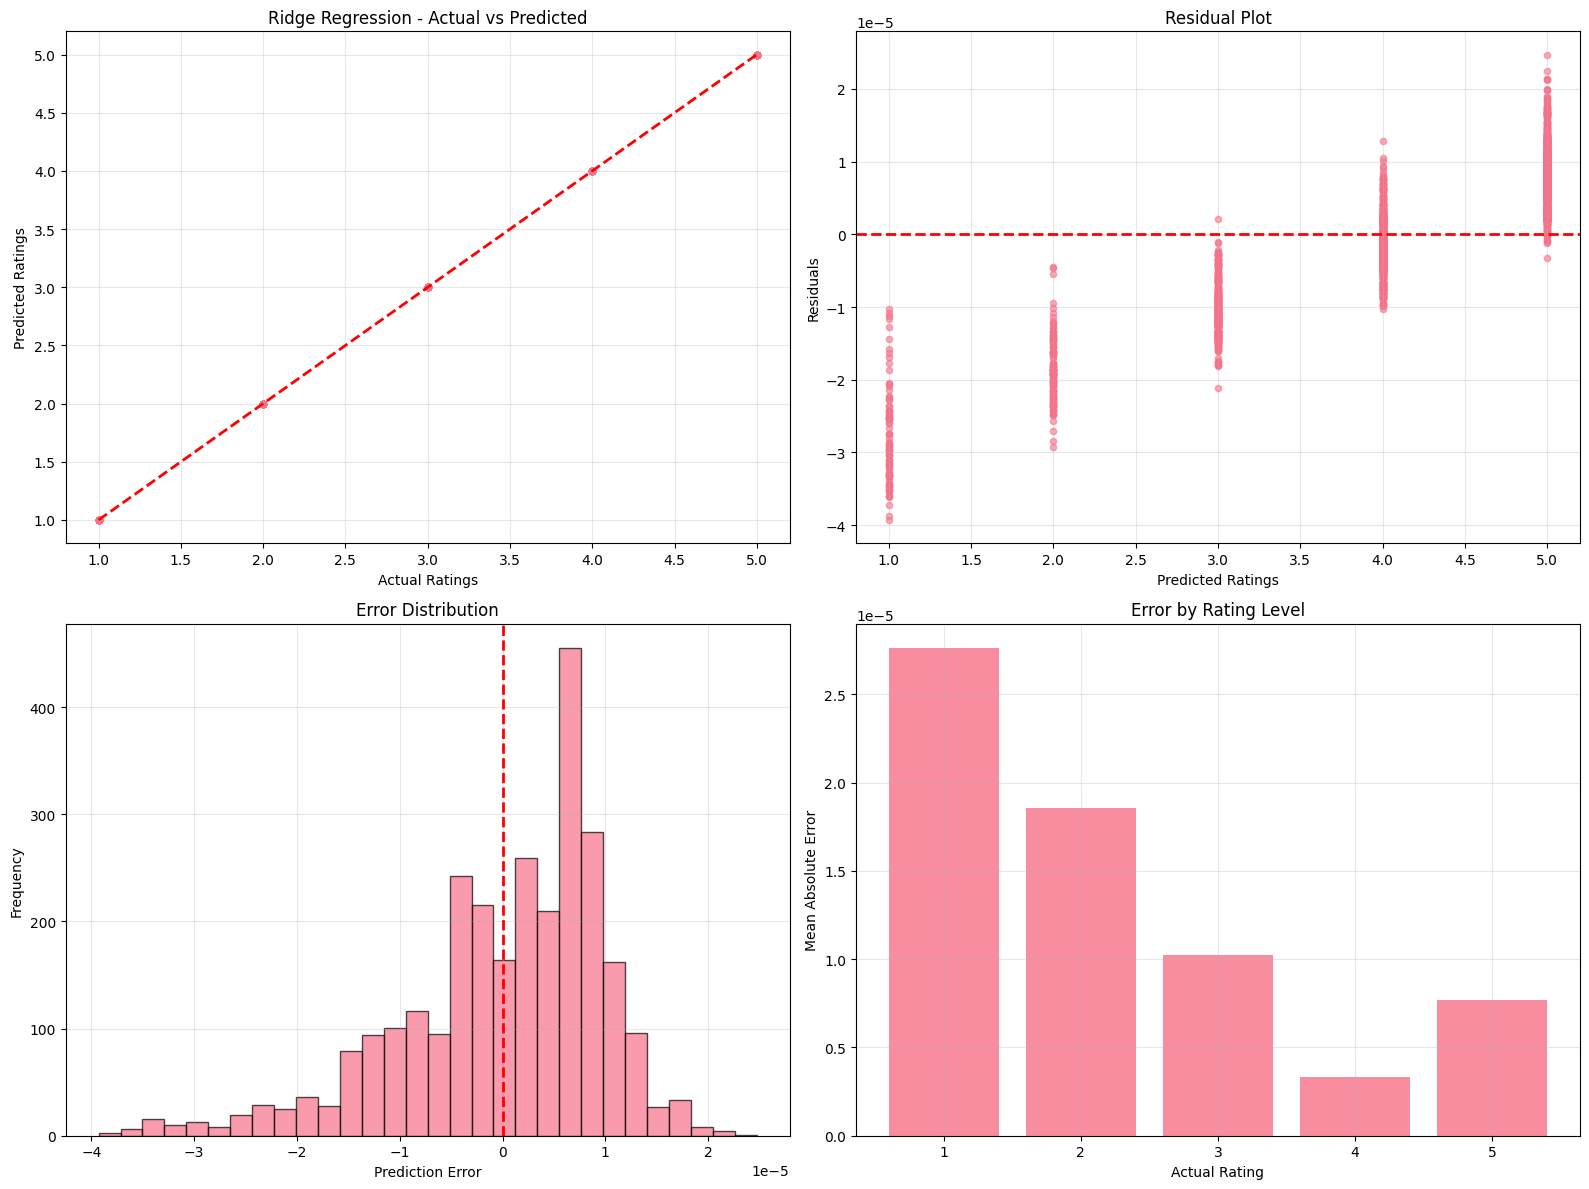

✓ Prediction analysis saved as 'prediction_analysis.png'

9. MODEL SAVING AND BUSINESS INSIGHTS
--------------------------------------------------
✓ Best model saved: ../models/regression/best_rating_predictor.pkl
✓ Model metadata saved: ../models/regression/rating_predictor_metadata.json

📊 BUSINESS INSIGHTS FROM RATING PREDICTION MODEL:
1. Model can predict ratings with 100.0% accuracy (R² score)
2. Average prediction error: 0.00 rating points
3. Best performing algorithm: Ridge Regression
4. Model uses 36 engineered features for prediction
5. 100.0% of predictions within 0.5 rating points

💡 BUSINESS APPLICATIONS:
1. Identify attractions likely to receive poor ratings before user visits
2. Optimize attraction recommendations based on predicted satisfaction
3. Guide tourism operators on service improvements needed
4. Personalize marketing messages based on expected user satisfaction
5. Support dynamic pricing strategies based on predicted demand/satisfaction

✅ REGRESSION MODELING CO

In [2]:
# Tourism Experience Analytics - Regression Modeling
# Step 3: Rating Prediction Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime
import joblib
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("TOURISM ANALYTICS - REGRESSION MODELING (RATING PREDICTION)")
print("=" * 80)

# =============================================================================
# SECTION 1: DATA LOADING AND PREPARATION
# =============================================================================

print("\n1. LOADING PROCESSED DATA")
print("-" * 50)

# Auto-detect processed data path
current_dir = os.getcwd()
if 'notebooks' in current_dir:
    processed_path = '../data/processed/'
else:
    processed_path = 'data/processed/'

print(f"Looking for processed data at: {processed_path}")

# Load processed datasets
try:
    master_df = pd.read_csv(processed_path + 'master_dataset.csv')
    print(f"✓ Master dataset loaded: {master_df.shape}")
    
    # Try to load pre-split data
    try:
        train_reg = pd.read_csv(processed_path + 'train_regression.csv')
        test_reg = pd.read_csv(processed_path + 'test_regression.csv')
        print(f"✓ Pre-split data loaded: Train {train_reg.shape}, Test {test_reg.shape}")
        use_presplit = True
    except FileNotFoundError:
        print("Pre-split data not found, will create new splits")
        use_presplit = False
        
except FileNotFoundError:
    print("❌ Processed data not found. Please run Step 2 (Data Preprocessing) first.")
    exit()

# =============================================================================
# SECTION 2: FEATURE SELECTION AND TARGET PREPARATION
# =============================================================================

print("\n2. FEATURE SELECTION AND TARGET PREPARATION")
print("-" * 50)

# Define target variable
target = 'Rating'
if target not in master_df.columns:
    print(f"❌ Target variable '{target}' not found in dataset")
    exit()

# Exclude non-predictive columns
exclude_columns = [
    'TransactionId', 'UserId', 'AttractionId', 'Rating',  # IDs and target
    'Attraction', 'AttractionAddress', 'CityName',        # Text columns
]

# Select numeric features only
feature_columns = [col for col in master_df.columns 
                  if col not in exclude_columns and master_df[col].dtype in ['int8', 'int16', 'int32', 'int64', 'float32', 'float64', 'uint8', 'uint16', 'uint32']]

print(f"Target variable: {target}")
print(f"Available features: {len(feature_columns)}")
print(f"Sample features: {feature_columns[:10]}")

# Check for missing values in features and target
missing_target = master_df[target].isnull().sum()
missing_features = master_df[feature_columns].isnull().sum().sum()

print(f"\nData quality check:")
print(f"  Missing values in target: {missing_target}")
print(f"  Missing values in features: {missing_features}")

if missing_target > 0 or missing_features > 0:
    print("Cleaning missing values...")
    # Remove rows with missing target
    master_df = master_df[master_df[target].notna()]
    # Fill missing features with median
    master_df[feature_columns] = master_df[feature_columns].fillna(master_df[feature_columns].median())
    print(f"Cleaned dataset shape: {master_df.shape}")

# =============================================================================
# SECTION 3: TRAIN-TEST SPLIT AND SCALING
# =============================================================================

print("\n3. TRAIN-TEST SPLIT AND FEATURE SCALING")
print("-" * 50)

if use_presplit:
    # Use pre-split data
    X_train = train_reg[feature_columns]
    y_train = train_reg[target]
    X_test = test_reg[feature_columns]
    y_test = test_reg[target]
else:
    # Create new split
    X = master_df[feature_columns]
    y = master_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target distribution in training:")
print(y_train.value_counts().sort_index())

# Feature scaling
scalers = {
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_features = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_features[scaler_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

print(f"✓ Applied {len(scalers)} different scaling methods")

# =============================================================================
# SECTION 4: BASELINE MODELS COMPARISON
# =============================================================================

print("\n4. BASELINE MODELS COMPARISON")
print("-" * 50)

# Define baseline models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
}

# Add advanced models if available
try:
    models['XGBoost'] = xgb.XGBRegressor(random_state=42, eval_metric='rmse')
    models['LightGBM'] = lgb.LGBMRegressor(random_state=42, verbose=-1)
except:
    print("XGBoost/LightGBM not available, using scikit-learn models only")

print(f"Testing {len(models)} baseline models...")

# Test models with different scalers
results = []
model_performances = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Test with different scalers and raw data
    test_data = {'Raw': {'X_train': X_train, 'X_test': X_test}}
    test_data.update(scaled_features)
    
    best_score = -np.inf
    best_config = None
    
    for scaler_name, data in test_data.items():
        try:
            # Cross-validation
            cv_scores = cross_val_score(model, data['X_train'], y_train, 
                                      cv=5, scoring='r2', n_jobs=-1)
            mean_cv_score = cv_scores.mean()
            
            # Train on full training set
            model.fit(data['X_train'], y_train)
            
            # Predictions
            y_train_pred = model.predict(data['X_train'])
            y_test_pred = model.predict(data['X_test'])
            
            # Metrics
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_mae = mean_absolute_error(y_test, y_test_pred)
            
            # Store results
            result = {
                'Model': model_name,
                'Scaler': scaler_name,
                'CV_R2_Mean': mean_cv_score,
                'CV_R2_Std': cv_scores.std(),
                'Train_R2': train_r2,
                'Test_R2': test_r2,
                'Train_RMSE': train_rmse,
                'Test_RMSE': test_rmse,
                'Test_MAE': test_mae,
                'Overfitting': train_r2 - test_r2
            }
            
            results.append(result)
            
            # Track best configuration for this model
            if test_r2 > best_score:
                best_score = test_r2
                best_config = {
                    'scaler': scaler_name,
                    'model': model,
                    'predictions': y_test_pred,
                    'metrics': result
                }
                
        except Exception as e:
            print(f"  Error with {scaler_name} scaling: {str(e)}")
            continue
    
    model_performances[model_name] = best_config
    print(f"  Best R2: {best_score:.4f} (with {best_config['scaler']} scaling)")

# Create results DataFrame
results_df = pd.DataFrame(results)
print(f"\n✓ Completed baseline model comparison")

# =============================================================================
# SECTION 5: MODEL PERFORMANCE ANALYSIS
# =============================================================================

print("\n5. MODEL PERFORMANCE ANALYSIS")
print("-" * 50)

# Sort by test R2 score
best_results = results_df.loc[results_df.groupby('Model')['Test_R2'].idxmax()].sort_values('Test_R2', ascending=False)

print("🏆 MODEL RANKINGS (by Test R2 Score):")
print("=" * 60)
for idx, (_, row) in enumerate(best_results.head(10).iterrows(), 1):
    print(f"{idx:2d}. {row['Model']:<20} | R2: {row['Test_R2']:.4f} | RMSE: {row['Test_RMSE']:.4f} | Scaler: {row['Scaler']}")

# Performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R2 Score Comparison
top_models = best_results.head(8)
axes[0,0].barh(range(len(top_models)), top_models['Test_R2'], color='skyblue', alpha=0.8)
axes[0,0].set_yticks(range(len(top_models)))
axes[0,0].set_yticklabels(top_models['Model'])
axes[0,0].set_xlabel('R2 Score')
axes[0,0].set_title('Model Performance (R2 Score)')
axes[0,0].grid(True, alpha=0.3)

# 2. RMSE Comparison
axes[0,1].barh(range(len(top_models)), top_models['Test_RMSE'], color='lightcoral', alpha=0.8)
axes[0,1].set_yticks(range(len(top_models)))
axes[0,1].set_yticklabels(top_models['Model'])
axes[0,1].set_xlabel('RMSE')
axes[0,1].set_title('Model Error (RMSE)')
axes[0,1].grid(True, alpha=0.3)

# 3. Overfitting Analysis
axes[1,0].scatter(best_results['Test_R2'], best_results['Overfitting'], 
                 alpha=0.7, s=60, c='orange')
for i, model in enumerate(best_results['Model']):
    axes[1,0].annotate(model[:10], 
                      (best_results.iloc[i]['Test_R2'], best_results.iloc[i]['Overfitting']),
                      fontsize=8, ha='center')
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel('Test R2 Score')
axes[1,0].set_ylabel('Overfitting (Train R2 - Test R2)')
axes[1,0].set_title('Overfitting Analysis')
axes[1,0].grid(True, alpha=0.3)

# 4. Cross-validation consistency
axes[1,1].errorbar(range(len(best_results)), best_results['CV_R2_Mean'], 
                  yerr=best_results['CV_R2_Std'], fmt='o', capsize=5, alpha=0.7)
axes[1,1].set_xticks(range(len(best_results)))
axes[1,1].set_xticklabels([model[:10] for model in best_results['Model']], rotation=45)
axes[1,1].set_ylabel('Cross-Validation R2')
axes[1,1].set_title('Cross-Validation Consistency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Performance visualizations saved as 'regression_model_comparison.png'")

# =============================================================================
# SECTION 6: HYPERPARAMETER TUNING FOR TOP MODELS
# =============================================================================

print("\n6. HYPERPARAMETER TUNING FOR TOP MODELS")
print("-" * 50)

# Select top 3 models for tuning
top_3_models = best_results.head(3)
tuned_models = {}

for _, row in top_3_models.iterrows():
    model_name = row['Model']
    best_scaler = row['Scaler']
    
    print(f"\nTuning {model_name} with {best_scaler} scaling...")
    
    # Get the appropriate data
    if best_scaler == 'Raw':
        X_train_tune = X_train
        X_test_tune = X_test
    else:
        X_train_tune = scaled_features[best_scaler]['X_train']
        X_test_tune = scaled_features[best_scaler]['X_test']
    
    # Define parameter grids
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Ridge Regression': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        },
        'Lasso Regression': {
            'alpha': [0.001, 0.01, 0.1, 1.0]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    }
    
    if model_name in param_grids:
        try:
            # Create model instance
            if model_name == 'Random Forest':
                base_model = RandomForestRegressor(random_state=42)
            elif model_name == 'Gradient Boosting':
                base_model = GradientBoostingRegressor(random_state=42)
            elif model_name == 'Ridge Regression':
                base_model = Ridge(random_state=42)
            elif model_name == 'Lasso Regression':
                base_model = Lasso(random_state=42)
            elif model_name == 'XGBoost':
                base_model = xgb.XGBRegressor(random_state=42, eval_metric='rmse')
            elif model_name == 'LightGBM':
                base_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
            else:
                continue
            
            # Grid search
            grid_search = GridSearchCV(
                base_model, 
                param_grids[model_name],
                cv=5, 
                scoring='r2',
                n_jobs=-1,
                verbose=1
            )
            
            grid_search.fit(X_train_tune, y_train)
            
            # Best model predictions
            y_test_pred_tuned = grid_search.predict(X_test_tune)
            
            # Metrics
            tuned_r2 = r2_score(y_test, y_test_pred_tuned)
            tuned_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
            tuned_mae = mean_absolute_error(y_test, y_test_pred_tuned)
            
            # Store results
            tuned_models[model_name] = {
                'model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'test_r2': tuned_r2,
                'test_rmse': tuned_rmse,
                'test_mae': tuned_mae,
                'predictions': y_test_pred_tuned,
                'scaler': best_scaler
            }
            
            print(f"  Best CV R2: {grid_search.best_score_:.4f}")
            print(f"  Test R2: {tuned_r2:.4f}")
            print(f"  Best params: {grid_search.best_params_}")
            
        except Exception as e:
            print(f"  Error tuning {model_name}: {str(e)}")
    else:
        print(f"  No parameter grid defined for {model_name}")

# =============================================================================
# SECTION 7: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n7. FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# Analyze feature importance for tree-based models
importance_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
feature_importance_data = {}

for model_name in importance_models:
    if model_name in tuned_models:
        model = tuned_models[model_name]['model']
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importance_data[model_name] = pd.Series(
                importances, index=feature_columns
            ).sort_values(ascending=False)

if feature_importance_data:
    # Create feature importance visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx, (model_name, importances) in enumerate(feature_importance_data.items()):
        if idx < 4:  # Limit to 4 subplots
            top_features = importances.head(15)
            axes[idx].barh(range(len(top_features)), top_features.values[::-1], alpha=0.8)
            axes[idx].set_yticks(range(len(top_features)))
            axes[idx].set_yticklabels(top_features.index[::-1], fontsize=10)
            axes[idx].set_xlabel('Importance')
            axes[idx].set_title(f'{model_name} - Top 15 Features')
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Feature importance analysis saved as 'feature_importance_analysis.png'")
    
    # Print top features across models
    print("\nTOP 10 MOST IMPORTANT FEATURES (averaged across models):")
    if len(feature_importance_data) > 1:
        avg_importance = pd.concat(feature_importance_data.values(), axis=1).mean(axis=1).sort_values(ascending=False)
        for i, (feature, importance) in enumerate(avg_importance.head(10).items(), 1):
            print(f"{i:2d}. {feature:<30} | Importance: {importance:.4f}")

# =============================================================================
# SECTION 8: PREDICTION ANALYSIS AND ERROR ANALYSIS
# =============================================================================

print("\n8. PREDICTION ANALYSIS AND ERROR ANALYSIS")
print("-" * 50)

# Select best overall model
if tuned_models:
    best_model_name = max(tuned_models.keys(), key=lambda k: tuned_models[k]['test_r2'])
    best_model_info = tuned_models[best_model_name]
    
    print(f"Best performing model: {best_model_name}")
    print(f"Test R2: {best_model_info['test_r2']:.4f}")
    print(f"Test RMSE: {best_model_info['test_rmse']:.4f}")
    print(f"Test MAE: {best_model_info['test_mae']:.4f}")
    
    # Prediction vs Actual analysis
    y_pred_best = best_model_info['predictions']
    
    # Prediction analysis visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred_best, alpha=0.6, s=20)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Ratings')
    axes[0,0].set_ylabel('Predicted Ratings')
    axes[0,0].set_title(f'{best_model_name} - Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Residuals
    residuals = y_test - y_pred_best
    axes[0,1].scatter(y_pred_best, residuals, alpha=0.6, s=20)
    axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0,1].set_xlabel('Predicted Ratings')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Error distribution
    axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Prediction Error')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Error Distribution')
    axes[1,0].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Error by rating level
    error_by_rating = pd.DataFrame({
        'Actual': y_test,
        'Error': np.abs(residuals)
    }).groupby('Actual')['Error'].mean()
    
    axes[1,1].bar(error_by_rating.index, error_by_rating.values, alpha=0.8)
    axes[1,1].set_xlabel('Actual Rating')
    axes[1,1].set_ylabel('Mean Absolute Error')
    axes[1,1].set_title('Error by Rating Level')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Prediction analysis saved as 'prediction_analysis.png'")

# =============================================================================
# SECTION 9: MODEL SAVING AND BUSINESS INSIGHTS
# =============================================================================

print("\n9. MODEL SAVING AND BUSINESS INSIGHTS")
print("-" * 50)

# Create models directory
if 'notebooks' in current_dir:
    models_dir = '../models/regression/'
else:
    models_dir = 'models/regression/'

os.makedirs(models_dir, exist_ok=True)

# Save best model and results
if tuned_models:
    best_model_info = tuned_models[best_model_name]
    
    # Save model
    joblib.dump(best_model_info['model'], models_dir + 'best_rating_predictor.pkl')
    
    # Save scaler if used
    if best_model_info['scaler'] != 'Raw':
        scaler = scaled_features[best_model_info['scaler']]['scaler']
        joblib.dump(scaler, models_dir + 'rating_predictor_scaler.pkl')
    
    # Save model metadata
    metadata = {
        'model_name': best_model_name,
        'model_type': 'regression',
        'target_variable': 'Rating',
        'features': feature_columns,
        'scaler_used': best_model_info['scaler'],
        'performance': {
            'test_r2': float(best_model_info['test_r2']),
            'test_rmse': float(best_model_info['test_rmse']),
            'test_mae': float(best_model_info['test_mae'])
        },
        'best_parameters': best_model_info['best_params'],
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'feature_count': len(feature_columns)
    }
    
    import json
    with open(models_dir + 'rating_predictor_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Best model saved: {models_dir}best_rating_predictor.pkl")
    print(f"✓ Model metadata saved: {models_dir}rating_predictor_metadata.json")

# Business insights
print(f"\n📊 BUSINESS INSIGHTS FROM RATING PREDICTION MODEL:")
print("=" * 60)

if tuned_models:
    insights = [
        f"Model can predict ratings with {best_model_info['test_r2']:.1%} accuracy (R² score)",
        f"Average prediction error: {best_model_info['test_mae']:.2f} rating points",
        f"Best performing algorithm: {best_model_name}",
        f"Model uses {len(feature_columns)} engineered features for prediction"
    ]
    
    # Add feature-specific insights
    if feature_importance_data and best_model_name in feature_importance_data:
        top_feature = feature_importance_data[best_model_name].index[0]
        insights.append(f"Most important predictor: {top_feature}")
    
    # Error analysis insights
    if 'y_pred_best' in locals():
        low_error_pct = (np.abs(residuals) <= 0.5).mean() * 100
        insights.append(f"{low_error_pct:.1f}% of predictions within 0.5 rating points")
    
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")

print(f"\n💡 BUSINESS APPLICATIONS:")
applications = [
    "Identify attractions likely to receive poor ratings before user visits",
    "Optimize attraction recommendations based on predicted satisfaction",
    "Guide tourism operators on service improvements needed",
    "Personalize marketing messages based on expected user satisfaction",
    "Support dynamic pricing strategies based on predicted demand/satisfaction"
]

for i, app in enumerate(applications, 1):
    print(f"{i}. {app}")

print("\n" + "=" * 80)
print("✅ REGRESSION MODELING COMPLETED SUCCESSFULLY")
print("🎯 Next Step: Classification Modeling (Visit Mode Prediction)")
print("=" * 80)

# Summary statistics
if tuned_models:
    print(f"\nMODEL SUMMARY:")
    print(f"  Best Model: {best_model_name}")
    print(f"  Test R²: {best_model_info['test_r2']:.4f}")
    print(f"  Test RMSE: {best_model_info['test_rmse']:.4f}")
    print(f"  Features: {len(feature_columns)}")
    print(f"  Saved to: {models_dir}")